There were a lot of issues with having google collab access sep after dowloading it through my terminal so instead, I had the download be a step of the script.

In [1]:
!pip install sep astropy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.9 MB/s eta 0:00:00


I had a lot of trouble directly taking the file from my storage through the script so I ended up using the file upload function instead. This process Takes about 20 minutes.

In [2]:
from google.colab import files

# Upload file (select your image.fits file)
uploaded = files.upload()

Saving min_jw02731-o001_t017_nircam_clear-f090w_i2d.fits to min_jw02731-o001_t017_nircam_clear-f090w_i2d.fits


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import sep
import matplotlib.pyplot as plt
from astropy.io import fits

# Load uploaded FITS file
fits_file = next(iter(uploaded))
with fits.open(fits_file) as hdul:
    data = hdul[0].data.astype(np.float32)  # Convert to float32

# View dimensions
print("Image shape:", data.shape)

Image shape: (8582, 14339)


In [7]:
# Estimate background and subtract it
bkg = sep.Background(data)

# Subtract background
data_sub = data - bkg

# Extract sources from background-subtracted image
objects = sep.extract(data_sub, thresh=10.0, err=bkg.globalrms)

print(f"Detected {len(objects)} sources.")

Detected 12006 sources.


With 12006 sources detected, we then move on to the image ganeration.

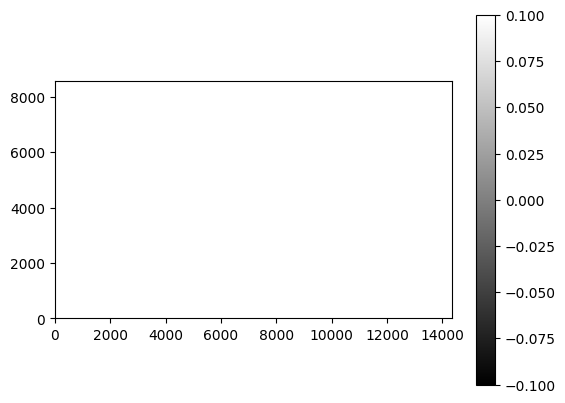

In [8]:
# show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

In [9]:
# measure a spatially varying background on the image
bkg = sep.Background(data)

In [10]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

1.1997147798538208
0.06582547724246979


In [11]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

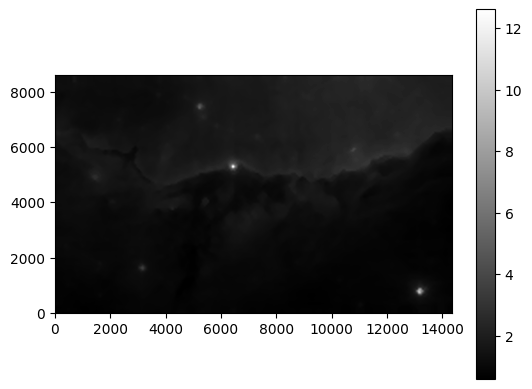

In [12]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [13]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

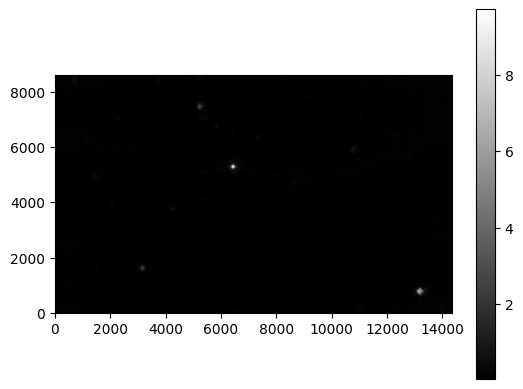

In [14]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

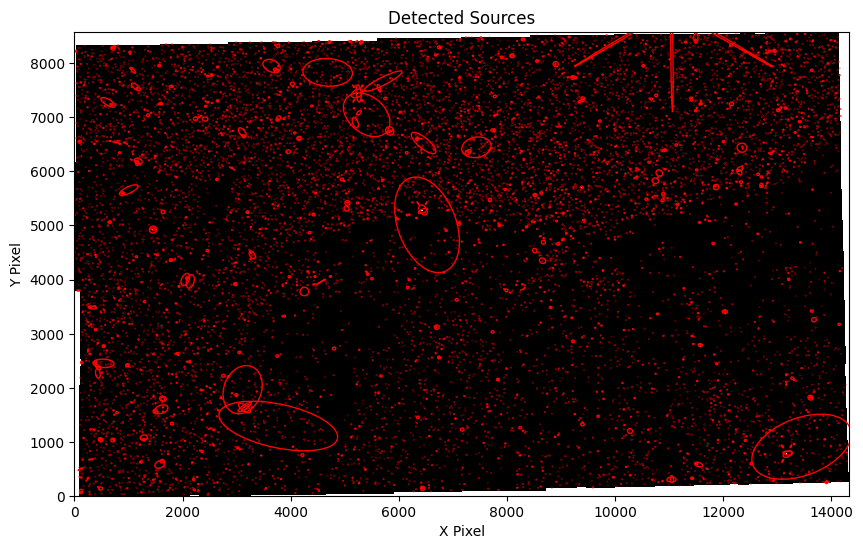

In [15]:
# Plot sources on top of subtracted image
fig, ax = plt.subplots(figsize=(10, 8))
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m - s, vmax=m + s, origin='lower')

# Draw ellipses for each source
for obj in objects:
    e = plt.matplotlib.patches.Ellipse(
        xy=(obj['x'], obj['y']),
        width=6 * obj['a'],
        height=6 * obj['b'],
        angle=obj['theta'] * 180. / np.pi,
        edgecolor='red',
        facecolor='none',
        linewidth=1)
    ax.add_patch(e)

plt.title("Detected Sources")
plt.xlabel("X Pixel")
plt.ylabel("Y Pixel")
plt.show()

In [ ]:
files.download("original_image.png") # Saves all the files as a PNG
files.download("background_model.png")
files.download("background_subtracted.png")
files.download("detected_sources.png")

What are the mean, median, and standard deviation of the distribution of fluxes. What is the largest outlier in the distribution, where is it on the image, and how many standard deviations is it away from the mean? (step 7)

Number of sources detected: 12006


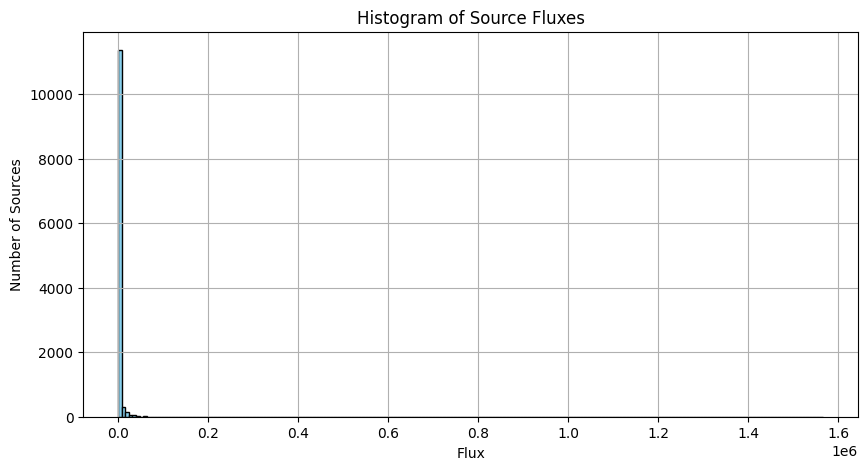

In [21]:
# Number of sources
num_sources = len(objects)
print(f"Number of sources detected: {num_sources}")

# Extract fluxes
fluxes = np.array([obj['flux'] for obj in objects])

# Plot histogram of fluxes
plt.figure(figsize=(10, 5))
plt.hist(fluxes, bins=200, color='skyblue', edgecolor='black')
plt.xlabel("Flux")
plt.ylabel("Number of Sources")
plt.title("Histogram of Source Fluxes")
plt.grid(True)
plt.savefig("flux_histogram.png", bbox_inches='tight')
plt.show()

In [17]:
# Calculate basic statistics
flux_mean = np.mean(fluxes)
flux_median = np.median(fluxes)
flux_std = np.std(fluxes)

print(f"Mean flux: {flux_mean:.2f}")
print(f"Median flux: {flux_median:.2f}")
print(f"Standard deviation of flux: {flux_std:.2f}")

# Find largest outlier
max_flux = np.max(fluxes)
max_flux_index = np.argmax(fluxes)
max_obj = objects[max_flux_index]
n_std_away = (max_flux - flux_mean) / flux_std

print(f"\nLargest flux: {max_flux:.2f}")
print(f"Location (x, y): ({max_obj['x']:.2f}, {max_obj['y']:.2f})")
print(f"Number of std deviations from mean: {n_std_away:.2f}σ")

Mean flux: 2693.64
Median flux: 60.04
Standard deviation of flux: 32344.85

Largest flux: 1565681.00
Location (x, y): (13195.70, 769.98)
Number of std deviations from mean: 48.32σ


In [ ]:
files.download("flux_histogram.png")

Reproject the 5 other files using this scriptLinks to an external site., using "clear-f090w" as a reference, and then load all the reprojected fits files into the same notebook. Make a 3-color false image of the NGC 3324 by combining all 6 images in any way of your choice. Save the image as a PNG. (step 8)

In [18]:
# ---------------------------------
# 0. Copy all this script into one cell, between steps 7 and 8 of your final project
#    You will need to install the "reproject" package with pip
#    This script will "reproject" all images onto the same shape using one image as a reference
# ---------------------------------

# Install reproject package
!pip install reproject

from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp

# ---------------------------------
# 1. Load your reference image
# ---------------------------------
# 0. Copy all this script into one cell, between steps 7 and 8 of your final project
#    You will need to install the "reproject" package with pip
#    This script will "reproject" all images onto the same shape using one image as a reference
# ---------------------------------

from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp

# ---------------------------------
# 1. Load your reference image
#    This will define the WCS and shape for all others
# ---------------------------------
file_reference = 'min_jw02731-o001_t017_nircam_clear-f090w_i2d.fits'
with fits.open(file_reference) as hdulist:
    # For JWST i2d images, 'SCI' is commonly the science extension
    ref_header = hdulist['SCI'].header
    ref_data = hdulist['SCI'].data

# Create a WCS object from the reference
ref_wcs = WCS(ref_header)

# This shape will be used for all reprojected images
output_shape = ref_data.shape

# ---------------------------------
# 2. Reproject the other images
# ---------------------------------
fname1 = 'min_jw02731-o001_t017_nircam_clear-f187n_i2d.fits' # [PATH TO OTHER FITS FILE HERE]
fname2 = 'min_jw02731-o001_t017_nircam_clear-f200w_i2d.fits' # [PATH TO OTHER FITS FILE HERE]
fname3 = 'min_jw02731-o001_t017_nircam_clear-f335m_i2d.fits' # [PATH TO OTHER FITS FILE HERE]
fname4 = 'min_jw02731-o001_t017_nircam_clear-f444w_i2d.fits' # [PATH TO OTHER FITS FILE HERE]
fname5 = 'min_jw02731-o001_t017_nircam_f444w-f470n_i2d.fits' # [PATH TO OTHER FITS FILE HERE]

other_filenames = [
    fname1,
    fname2,
    fname3,
    fname4,
    fname5,
]

# Reproject all other files according to the reference
for fname in other_filenames:
    with fits.open(fname) as hdulist:
        data = hdulist['SCI'].data
        header = hdulist['SCI'].header
        wcs_in = WCS(header)

    # Reproject this image onto the reference WCS
    # reproject_interp returns (reprojected_data, footprint)
    reprojected_data, footprint = reproject_interp(
        (data, wcs_in),
        ref_wcs,
        shape_out=output_shape
    )

    # Optionally, update the header to match the reference WCS
    # so that the new FITS is self-consistent
    new_header = ref_header.copy()

    # Save the new file
    out_name = fname.replace('.fits', '_reproj.fits')
    hdu = fits.PrimaryHDU(reprojected_data, header=new_header)
    hdu.writeto(out_name, overwrite=True)
    print(f"Reprojected {fname} -> {out_name}")
    ref_header = hdulist['SCI'].header
    ref_data = hdulist['SCI'].data

# Create a WCS object from the reference
ref_wcs = WCS(ref_header)

# This shape will be used for all reprojected images
output_shape = ref_data.shape

# ---------------------------------

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.2/195.2 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.4/205.4 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 5.6 MB/s eta 0:00:00


FileNotFoundError: [Errno 2] No such file or directory: 'jw02731-o001_t017_nircam_clear-f090w.fits'

Unfortunately I have been unable to get the script to actually find the file within my computer. This code is my best approximation of a working version.